# Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.linear_model import LogisticRegression

plt.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
cases = pd.read_csv('Data.nosync/Similar_TM.csv')
cases.sample(20)

,TM_A,TM_B,target
51,Halloumi,Hajdu Halloumi,1
185,360 CONSULT,360 WORKPLACE,1
194,Percipio,PERCIPIO BY SKILLSOFT,1
224,CANDEY,Candey Parker,1
409,CLINIQUE LA PRAIRIE,CLINIQUE,1
177,KOTO,Kozo,1
373,DISOBEY,OBEY,1
312,GTE,GTF,0
379,ZECO,ZICO1973,1
389,INTABALL,INTA,1


In [3]:
import unidecode
from fuzzywuzzy import fuzz
import jellyfish

from abydos.distance import (IterativeSubString, BISIM, DiscountedLevenshtein, Prefix, LCSstr, MLIPNS, Strcmp95,
MRA, Editex, SAPS, FlexMetric, JaroWinkler, HigueraMico, Sift4, Eudex, ALINE, PhoneticEditDistance)

from abydos.phonetic import PSHPSoundexFirst, Ainsworth
pshp_soundex_first = PSHPSoundexFirst()
pe = Ainsworth()

In [4]:
iss = IterativeSubString()
bisim = BISIM()
dlev = DiscountedLevenshtein()
prefix = Prefix()
lcs = LCSstr()
mlipns = MLIPNS()
strcmp95 = Strcmp95()
mra = MRA()
editex = Editex()
saps = SAPS()
flexmetric = FlexMetric()
jaro = JaroWinkler(mode='Jaro')
higuera_mico = HigueraMico()
sift4 = Sift4()
eudex = Eudex()
aline = ALINE()
phonetic_edit = PhoneticEditDistance()

In [5]:
algos = [iss, bisim, dlev, prefix, lcs, mlipns, strcmp95, mra, editex, saps, flexmetric, jaro, higuera_mico, sift4, eudex,
         aline, phonetic_edit]

algo_names = ['iterativesubstring', 'bisim', 'discountedlevenshtein', 'prefix', 'lcsstr', 'mlipns', 'strcmp95', 'mra',
              'editex', 'saps', 'flexmetric', 'jaro', 'higueramico', 'sift4', 'eudex', 'aline',
              'phoneticeditdistance']

In [6]:
from abydos.phones import *

In [7]:
def sum_ipa(name_a, name_b):
    feat1 = ipa_to_features(pe.encode(name_a))
    feat2 = ipa_to_features(pe.encode(name_b))
    if len(feat1) <= 1:
        score = sum(cmp_features(f1, f2) for f1, f2 in zip(feat1, feat2))/1
    else:    
        score = sum(cmp_features(f1, f2) for f1, f2 in zip(feat1, feat2))/len(feat1)
    return score

In [8]:
import re

In [9]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

def featurize(df):
    if len(df.columns)==3:
        df.columns=['a', 'b', 'target']
    elif len(df.columns)==2:
        df.columns=['a', 'b']
    else:
        df = df.rename(columns={df.columns[0]: 'a', df.columns[1]: 'b' })
        
    df['TM_A'] = df.apply(lambda row: re.sub(
        '[^a-zA-Z]+', '', unidecode.unidecode(row['a']).lower()), axis=1)
    df['TM_B'] = df.apply(lambda row: re.sub(
        '[^a-zA-Z]+', '', unidecode.unidecode(row['b']).lower()), axis=1)
    
    df['partial'] = df.apply(lambda row: fuzz.partial_ratio(row.TM_A,row.TM_B), axis=1)
    df['tkn_sort'] = df.apply(lambda row: fuzz.token_sort_ratio(row.TM_A,row.TM_B), axis=1)
    df['tkn_set'] = df.apply(lambda row: fuzz.token_set_ratio(row.TM_A,row.TM_B), axis=1)
    
    df['sum_ipa'] = df.apply(lambda row: sum_ipa(row.TM_A,row.TM_B), axis=1)
    
    # Jellyfish levenshtein
    df['levenshtein']= df.apply(lambda row: jellyfish.levenshtein_distance(row.TM_A,row.TM_B), axis=1)
    # Scale Levenshtein column
    scaler = MinMaxScaler()
    df['levenshtein'] = scaler.fit_transform(df['levenshtein'].values.reshape(-1,1))

    # Jellyfish phoneme
    df['metaphone'] = df.apply(
        lambda row: 1 if jellyfish.metaphone(row.TM_A)==jellyfish.metaphone(row.TM_B) else 0, axis=1)
    df['nysiis'] = df.apply(
        lambda row: 1 if jellyfish.nysiis(row.TM_A)==jellyfish.nysiis(row.TM_B) else 0, axis=1)
    df['mtch_rtng_cdx'] = df.apply(
        lambda row: 1 if jellyfish.match_rating_codex(row.TM_A)==jellyfish.match_rating_codex(row.TM_B) else 0, axis=1)
    
    df['pshp_soundex_first'] = df.apply(
        lambda row: 1 if pshp_soundex_first.encode(row.TM_A)==pshp_soundex_first.encode(row.TM_B) else 0, axis=1)
    
    for i, algo in enumerate(algos):
            df[algo_names[i]] = df.progress_apply(lambda row: algo.sim(row.TM_A, row.TM_B), axis=1)

    
    return df

In [10]:
# featurize(cases)

### Class Balancing  
We can see that the classes are imbalanced, there are more instances of trademark invalidation than are dismissals.

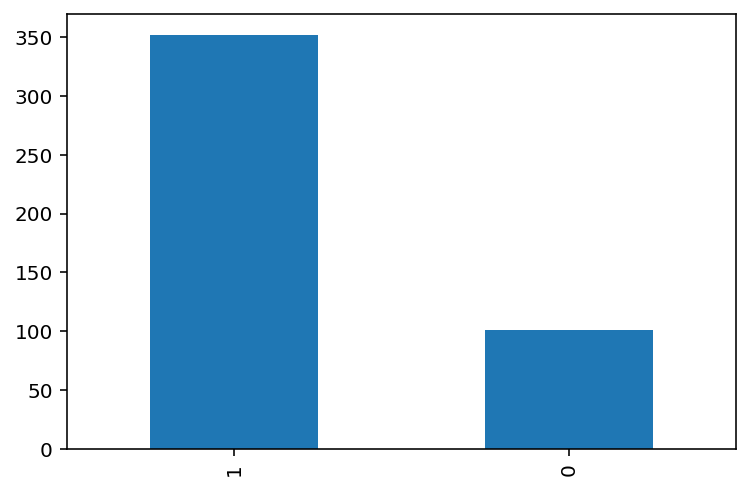

In [11]:
cases['target'].value_counts()[:2].plot(kind='bar')

# plt.savefig('TM_Unbalanced.png', dpi = 300)

In [12]:
from itertools import combinations
import random
random.seed(42)


In [13]:
# Use combinatorics to generate negative class
pos_cases = cases[cases['target'] == 1]

case_names = pos_cases.loc[:, 'TM_A':'TM_B'].values.tolist()
unique_cases = list(set([item for items in case_names for item in items]))
alt_pairs = list(zip(pos_cases.TM_A, pos_cases.TM_B))+ list(zip(pos_cases.TM_B, pos_cases.TM_A))
comb = list(combinations(unique_cases, 2))
nonmatch_cases = list(set(comb) - set(alt_pairs))
# Undersample the negative class for 1:4 class imbalance instead of 1:1000 extreme class imbalance
nonmatch_cases = pd.DataFrame(random.choices(nonmatch_cases, k=250), columns=['TM_A', 'TM_B']) # Originally was 1200

nonmatch_cases

,TM_A,TM_B
0,WEALTHSMART,ITP
1,Artigiano,TIME HEALTH
2,Ldnr,PURE IPR
3,Tilly’s Garden Party Hire,SKIN OLOGY
4,MONT,TREADSTONE
...,...,...
245,Jaked,KNOCK OUT
246,DOCTORnow,THE HOBBIT
247,ENVY,CALLA
248,SOFTY TOUCH,CELIO


In [14]:
print('positive class ratio 1:{}'.format(int(len(nonmatch_cases)/len(pos_cases))))

positive class ratio 1:0


In [15]:
nonmatch_cases.sample(20)

,TM_A,TM_B
17,MULTIVAN,MILAN SWEETS
211,DOCTORnow,The Science of Stoke
194,Tilly’s Garden Party Hire,PURE IPR
20,Zirco,GAZIANTEPLILER PASTANESI
157,Untangle,ayurvedic up&go
184,SKIN OLOGY,TRAVELERS
192,Suisman & Shapiro,Silarom
59,HCP,WHEALTH HEALTH IS THE REAL WEALTH
88,CAYA,The Organised Mum
72,Wrigleys drinks company,All Together Better


In [16]:
# Negative Class
nonmatch_cases['target'] = 0
df = pd.concat([pos_cases, nonmatch_cases])
# non_match_cases = None
# pos_cases = None

# Add true negatives
neg_cases = cases[cases['target'] == 0]
class_balanced = pd.concat([df, neg_cases])

class_balanced.sample(20)

# class_balanced[class_balanced['TM_B'].str.len()!=0]


,TM_A,TM_B,target
99,Karex,carexy,1
38,IBM,WHITESPACE,0
94,PEPE,HORIZON RISK SOLUTIONS,0
127,DERMAVEEL,GALATOPOLY,0
37,VESPER,ADAPT ACCOUNTANCY,0
200,RAW,RAWKUS,1
295,FIDELITY,FIDERES,0
367,SUBURBIA,THE SUBURBS,1
215,FABER-CASTELL,LUMESSE,0
178,C3 EX MACHINA,Fashion two twenty,0


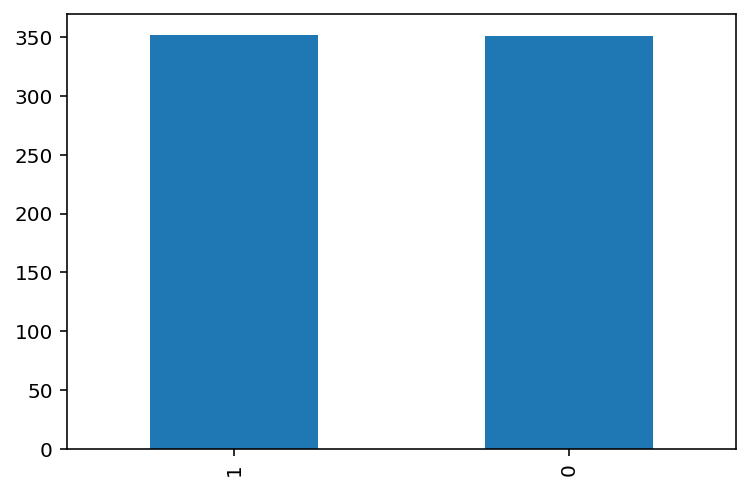

In [17]:
class_balanced['target'].value_counts()[:2].plot(kind='bar')

# plt.savefig('TM_Balanced.png', dpi = 300)

In [18]:
from tqdm.autonotebook import tqdm
tqdm.pandas()

df = featurize(class_balanced)
df.sample(20)

<ipython-input-18-213a59b7ad7e>:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/Users/seannguyen/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


,a,b,target,TM_A,TM_B,partial,tkn_sort,tkn_set,sum_ipa,levenshtein,metaphone,nysiis,mtch_rtng_cdx,pshp_soundex_first,iterativesubstring,bisim,discountedlevenshtein,prefix,lcsstr,mlipns,strcmp95,mra,editex,saps,flexmetric,jaro,higueramico,sift4,eudex,aline,phoneticeditdistance
228,ICELANDER,Hyflex,0,icelander,hyflex,33,27,27,0.649194,0.225806,0,0,0,0,0.000000,0.166667,0.198477,0.000000,0.111111,0.0,0.407407,0.000000,0.222222,0.000000,0.416667,0.351852,0.176587,0.111111,0.518627,0.302128,0.562724
45,TREADSTONE,BLUE.COM,0,treadstone,bluecom,29,24,24,0.620968,0.290323,0,0,0,0,0.000000,0.200000,0.100494,0.000000,0.100000,0.0,0.543810,0.000000,0.300000,0.000000,0.300000,0.495238,0.118434,0.200000,0.670098,0.420370,0.614516
149,MONSTAVAPE,MONSTER ENERGY,1,monstavape,monsterenergy,60,52,52,0.867384,0.225806,0,0,0,1,0.663768,0.461538,0.561045,0.500000,0.384615,0.0,0.844154,0.500000,0.538462,0.232558,0.507692,0.687179,0.441142,0.538462,0.989706,0.571831,0.717122
293,EEZEEVET,EASIPETCARE LTD,0,eezeevet,easipetcareltd,38,36,36,0.967742,0.322581,0,0,0,1,0.050000,0.250000,0.287852,0.125000,0.142857,0.0,0.570833,0.000000,0.428571,0.000000,0.500000,0.511905,0.180581,0.357143,0.914706,0.332432,0.543779
202,WILLOW,KANZ,0,willow,kanz,0,0,0,0.564516,0.193548,0,0,0,0,0.000000,0.000000,0.031444,0.000000,0.000000,0.0,0.000000,0.000000,0.250000,0.000000,0.183333,0.000000,0.000000,0.000000,0.869118,0.115385,0.559140
128,VERVE,Coco’s Liberty,0,verve,cocosliberty,40,24,24,0.696774,0.322581,0,0,0,0,0.000000,0.166667,0.184122,0.000000,0.166667,0.0,0.484444,0.000000,0.208333,0.000000,0.304167,0.427778,0.000000,0.083333,0.767647,0.270313,0.387097
144,PURE IPR,PURE IDEAS,1,pureipr,pureideas,71,62,62,0.972350,0.129032,0,0,0,1,0.812028,0.611111,0.648893,0.714286,0.555556,0.0,0.853968,0.666667,0.611111,0.375000,0.677778,0.756614,0.541667,0.555556,0.947549,0.623256,0.741935
16,Tailored T,Tailor-Tee,1,tailoredt,tailortee,78,78,78,0.796774,0.096774,0,0,0,1,0.832432,0.777778,0.748444,0.666667,0.666667,1.0,0.930556,0.833333,0.722222,0.482759,0.866667,0.884259,0.700000,0.777778,0.931373,0.744681,0.826165
59,HCP,WHEALTH HEALTH IS THE REAL WEALTH,0,hcp,whealthhealthistherealwealth,33,6,6,0.618280,0.870968,0,0,0,0,0.000000,0.035714,0.069255,0.000000,0.035714,0.0,0.493254,0.000000,0.250000,0.000000,0.333929,0.456349,0.000000,0.035714,0.868137,0.113514,0.095046
69,WHOLE FOOD EARTH,INDIES,0,wholefoodearth,indies,33,20,20,0.530645,0.419355,0,0,0,0,0.000000,0.107143,0.104969,0.000000,0.071429,0.0,0.373016,0.000000,0.321429,0.000000,0.375000,0.325397,0.000000,0.071429,0.621569,0.221429,0.396313


#### Export clean data to csv

In [19]:
# df.to_csv('Data.nosync/TM_features.csv', index=False)  

In [25]:
y = df.target
X = df.drop(columns = 'target')

X
y

0      1
1      1
2      1
3      1
4      1
      ..
437    0
444    0
445    0
446    0
450    0
Name: target, Length: 703, dtype: int64

In [21]:
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train

,a,b,TM_A,TM_B,partial,tkn_sort,tkn_set,sum_ipa,levenshtein,metaphone,nysiis,mtch_rtng_cdx,pshp_soundex_first,iterativesubstring,bisim,discountedlevenshtein,prefix,lcsstr,mlipns,strcmp95,mra,editex,saps,flexmetric,jaro,higueramico,sift4,eudex,aline,phoneticeditdistance
165,DRIVEONE,DRIVEON.NET,driveone,driveonnet,88,89,89,1.000000,0.064516,0,0,0,1,0.908499,0.800000,0.849190,0.875000,0.700000,1.0,0.960000,0.833333,0.900000,0.866667,0.960000,0.933333,0.788889,0.800000,0.839216,0.777778,0.800000
234,Knockout Clothing,KNOCK OUT,knockoutclothing,knockout,100,67,67,0.461538,0.258065,0,0,0,1,0.900000,0.500000,0.614836,1.000000,0.500000,0.0,0.900000,0.500000,0.531250,0.137255,0.615625,0.833333,0.337128,0.500000,0.873529,0.489130,0.500000
358,FABER-CASTELL,CASTELLI,fabercastell,castelli,93,70,70,0.424731,0.193548,0,0,0,0,0.817277,0.541667,0.457015,0.000000,0.583333,0.0,0.745040,0.500000,0.500000,0.324324,0.545833,0.724206,0.460800,0.250000,0.800490,0.602941,0.583333
266,WILDWOOD KITCHEN,WILD AND WOOD COFFEE HOUSE,wildwoodkitchen,wildandwoodcoffeehouse,60,59,59,0.833333,0.419355,0,0,0,0,0.668757,0.454545,0.498841,0.266667,0.227273,0.0,0.825818,0.666667,0.590909,0.209677,0.643182,0.698485,0.366546,0.454545,0.986275,0.487324,0.642962
110,GLENFIDDICH,Glenfield,glenfiddich,glenfield,78,70,70,0.763930,0.161290,0,0,0,1,0.791348,0.636364,0.646030,0.666667,0.545455,0.0,0.894949,0.500000,0.681818,0.555556,0.718182,0.804714,0.559091,0.636364,0.994608,0.653846,0.769795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,Eden Pure,Eden Aesthetics,edenpure,edenaesthetics,62,45,45,0.881048,0.290323,0,0,0,0,0.619697,0.357143,0.457191,0.500000,0.285714,0.0,0.680357,0.500000,0.392857,0.000000,0.535714,0.660714,0.252009,0.357143,0.976961,0.278378,0.543779
106,SOHO GARDEN,SOHO HOUSE,sohogarden,sohohouse,56,53,53,0.740143,0.161290,0,0,0,1,0.646890,0.500000,0.581428,0.444444,0.400000,0.0,0.823778,0.000000,0.550000,0.266667,0.535000,0.685185,0.500000,0.500000,0.986275,0.451852,0.803226
271,SHAPING THE WORLD OF WORK,POWERING THE WORLD OF WORK,shapingtheworldofwork,poweringtheworldofwork,81,84,84,0.703735,0.161290,0,0,0,0,0.866480,0.772727,0.651004,0.000000,0.772727,0.0,0.752934,0.500000,0.795455,0.636364,0.795455,0.743627,0.772727,0.818182,0.570098,0.795652,0.912757
83,GROSVENOR,VIFON,grosvenor,vifon,40,29,29,0.387097,0.225806,0,0,0,0,0.000000,0.222222,0.236697,0.000000,0.111111,0.0,0.571852,0.000000,0.277778,0.000000,0.322222,0.540741,0.121032,0.222222,0.624510,0.303922,0.516129


In [23]:
#X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1)

## TPOT AutoML pipeline

In [ ]:
from tpot import TPOTClassifier

In [ ]:
# pipeline_optimizer = TPOTClassifier(
#         scoring = 'f1', 
#         generations=100,
#         verbosity=2,
#         n_jobs=-1   # Utilizes all available CPU cores
#         ) 
# pipeline_optimizer.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1), y_train)

In [ ]:
# print(pipeline_optimizer.score(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y_test))

### Export TPOT pipeline

In [ ]:
# pipeline_optimizer.export('tpot_exported_calssifier_pipeline.py')

### Load TPOT pipeline

In [31]:
df_TPOT = df.drop(columns = ['a','b','TM_A','TM_B'])
df_TPOT

,target,partial,tkn_sort,tkn_set,sum_ipa,levenshtein,metaphone,nysiis,mtch_rtng_cdx,pshp_soundex_first,iterativesubstring,bisim,discountedlevenshtein,prefix,lcsstr,mlipns,strcmp95,mra,editex,saps,flexmetric,jaro,higueramico,sift4,eudex,aline,phoneticeditdistance
0,1,57,50,50,0.658986,0.161290,0,0,0,0,0.485480,0.388889,0.383752,0.000,0.333333,0.0,0.722751,0.666667,0.555556,0.137931,0.566667,0.671958,0.430556,0.444444,0.654902,0.602128,0.727599
1,1,38,38,38,0.691532,0.161290,0,0,0,0,0.050000,0.437500,0.366778,0.125,0.250000,0.0,0.633333,0.500000,0.500000,0.304348,0.400000,0.583333,0.375000,0.375000,0.916667,0.545455,0.897177
2,1,89,73,73,0.806452,0.096774,0,0,0,0,0.821263,0.583333,0.495199,0.000,0.666667,0.0,0.822222,0.833333,0.500000,0.428571,0.600000,0.822222,0.547619,0.666667,0.786275,0.705882,0.634409
3,1,83,83,83,0.895161,0.096774,0,0,0,1,0.884677,0.833333,0.818487,0.750,0.750000,1.0,0.933333,0.500000,0.833333,0.666667,0.833333,0.888889,0.769231,0.833333,1.000000,0.873529,0.913978
4,1,74,65,65,0.743176,0.290323,0,0,0,0,0.951613,0.588235,0.472052,0.000,0.529412,0.0,0.700700,0.000000,0.588235,0.319149,0.538235,0.687675,0.490372,0.588235,0.463725,0.589655,0.646110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,0,62,43,43,0.905242,0.483871,0,0,0,1,0.577381,0.275000,0.368095,0.500,0.200000,0.0,0.625000,0.000000,0.275000,0.000000,0.417500,0.625000,0.000000,0.250000,0.991176,0.308000,0.386290
444,0,80,73,73,0.925806,0.064516,0,0,0,1,0.875809,0.750000,0.732861,0.800,0.666667,1.0,0.915333,0.833333,0.750000,0.476190,0.691667,0.822222,0.666667,0.666667,0.983333,0.729412,0.817204
445,0,100,83,83,0.488479,0.064516,0,0,0,0,0.916667,0.642857,0.664079,0.000,0.714286,0.0,0.904762,0.833333,0.714286,0.500000,0.800000,0.904762,0.690476,0.714286,0.662745,0.729730,0.714286
446,0,100,80,80,0.615385,0.129032,0,0,0,1,0.940000,0.666667,0.750388,1.000,0.666667,1.0,0.933333,0.500000,0.666667,0.476190,0.708333,0.888889,0.614646,0.666667,1.000000,0.666667,0.666667


In [32]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.preprocessing import FunctionTransformer
from copy import copy

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = df_TPOT
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=None)

# Average CV score on the training set was: 0.8945711361541637
exported_pipeline = make_pipeline(
    make_union(
        FunctionTransformer(copy),
        FunctionTransformer(copy)
    ),
    GradientBoostingClassifier(learning_rate=0.01, max_depth=3, max_features=0.5,
                               min_samples_leaf=10, min_samples_split=3, 
                               n_estimators=100, subsample=0.9500000000000001)
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

results

array([1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0])

In [33]:
def base_model_1(X_train, y_train, X_test, export = False) :
    exported_pipeline = make_pipeline(
    GradientBoostingClassifier(
        learning_rate=0.01, 
        max_depth=3, max_features=0.5,
        min_samples_leaf=10, min_samples_split=3, 
        n_estimators=100, subsample=0.9500000000000001)
    )

    exported_pipeline.fit(X_train, y_train)
    if export==True:
        return exported_pipeline
    else:
        y_pred = exported_pipeline.predict_proba(X_test)
        return [p[1] for p in y_pred]

In [34]:
base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1), 
             y_train, X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

[0.19154704261736272,
 0.7032455574647665,
 0.7420181330567381,
 0.18895442302229276,
 0.6718179994965521,
 0.2015578144490875,
 0.2292028479962141,
 0.650476878763127,
 0.20297909654054846,
 0.5828643794512723,
 0.1884517173489056,
 0.646536114630922,
 0.2668988401426,
 0.518764550605617,
 0.6161594388725918,
 0.6884063376013978,
 0.7408792248862576,
 0.6728064360880214,
 0.6744577637996145,
 0.6803298361896676,
 0.2718127444419016,
 0.6592437437826221,
 0.1884517173489056,
 0.31381687989788276,
 0.1884517173489056,
 0.36903909906599286,
 0.7046877802848138,
 0.26620263368656577,
 0.6907726102110894,
 0.6732843896084616,
 0.651706534824001,
 0.6843972460423917,
 0.7236823706106474,
 0.7394567544270172,
 0.1951601685547114,
 0.6650725728278534,
 0.7232531546871654,
 0.616039425792033,
 0.18895442302229276,
 0.28590694667546745,
 0.5389325880155428,
 0.7438335479948596,
 0.18936029071693236,
 0.38076661108199855,
 0.6246585245731853,
 0.5188032425941121,
 0.2350053698782694,
 0.68075054

# K-fold cross validation

In [35]:
from sklearn.model_selection import StratifiedKFold

In [36]:
pd.options.mode.chained_assignment = None

# Stratified K-Folds cross-validator
meta_training = pd.DataFrame()

stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

fold = 1
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    oof_pred = X_test[['TM_A', 'TM_B']]
    
    oof_pred['predict_proba'] = base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1),
                                      y_train,
                                      X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))
    
    oof_pred['target'] = y_test.tolist()
    
    print('completed fold {} of 10'.format(fold))
    fold += 1

    meta_training = meta_training.append(oof_pred)

completed fold 1 of 10
completed fold 2 of 10
completed fold 3 of 10
completed fold 4 of 10
completed fold 5 of 10
completed fold 6 of 10
completed fold 7 of 10
completed fold 8 of 10
completed fold 9 of 10
completed fold 10 of 10


In [37]:
meta_training.sample(20)

,TM_A,TM_B,predict_proba,target
146,banilla,related,0.346502,0
344,quilt,quit,0.714400,0
125,fenestrae,finastra,0.699900,1
64,motimahal,galaxy,0.188466,0
338,growlerbeersuk,gruntinggrowler,0.526304,0
184,skinology,travelers,0.191521,0
177,dankvapes,allstarlanes,0.211206,0
298,theharleystreeteyeclinic,theharleystreetclinic,0.682999,0
137,aadvantage,hardcore,0.196384,0
225,totalmotionaffinityscheme,caffegusto,0.241014,0


### Meta-Model: Logistic Regression

In [38]:
df=featurize(meta_training)

In [39]:
df.sample(20)

,a,b,predict_proba,target,TM_A,TM_B,partial,tkn_sort,tkn_set,sum_ipa,levenshtein,metaphone,nysiis,mtch_rtng_cdx,pshp_soundex_first,iterativesubstring,bisim,discountedlevenshtein,prefix,lcsstr,mlipns,strcmp95,mra,editex,saps,flexmetric,jaro,higueramico,sift4,eudex,aline,phoneticeditdistance
214,laurentaylor,alexandredeparis,0.247588,0,laurentaylor,alexandredeparis,42,43,43,0.625806,0.387097,0,0,0,0,0.000000,0.281250,0.285044,0.000000,0.125000,0.0,0.636706,0.000000,0.343750,0.000000,0.368750,0.578373,0.251893,0.250000,0.605392,0.363095,0.654234
233,neverweather,neverwet,0.705057,1,neverweather,neverwet,88,80,80,0.867384,0.129032,0,0,0,1,0.877277,0.625000,0.747172,0.875000,0.583333,0.0,0.933333,0.500000,0.750000,0.531250,0.762500,0.888889,0.614646,0.666667,0.906373,0.683333,0.666667
157,untangle,ayurvedicupgo,0.196625,0,untangle,ayurvedicupgo,25,19,19,0.629032,0.387097,0,0,0,0,0.000000,0.153846,0.118901,0.000000,0.076923,0.0,0.464530,0.000000,0.230769,0.000000,0.311538,0.424145,0.037723,0.153846,0.601961,0.298413,0.547146
132,totalmotionaffinityscheme,affinityleasing,0.572475,1,totalmotionaffinityscheme,affinityleasing,62,45,45,0.396628,0.580645,0,0,0,0,0.529708,0.360000,0.272668,0.000000,0.320000,0.0,0.688684,0.000000,0.360000,0.000000,0.404000,0.667350,0.194579,0.280000,0.660784,0.376336,0.532903
7,woodystout,woodybrownale,0.695358,1,woodystout,woodybrownale,60,52,52,0.946237,0.225806,0,0,0,0,0.663768,0.500000,0.566645,0.500000,0.384615,0.0,0.822923,0.500000,0.538462,0.105263,0.550000,0.687179,0.441142,0.461538,0.835294,0.485714,0.727047
26,camcap,rodrigonewyork,0.199839,0,camcap,rodrigonewyork,0,0,0,0.798387,0.451613,0,0,0,0,0.000000,0.000000,0.051984,0.000000,0.000000,0.0,0.000000,0.000000,0.142857,0.000000,0.107143,0.000000,0.000000,0.000000,0.619118,0.125714,0.357143
168,tss,iss,0.610617,1,tss,iss,67,67,67,0.733871,0.032258,0,0,0,0,0.000000,0.500000,0.648604,0.000000,0.666667,1.0,0.777778,0.833333,0.666667,0.000000,0.666667,0.777778,0.666667,0.666667,0.623529,0.666667,0.822581
317,rawpassionorganicveganskinfood,raw,0.556056,0,rawpassionorganicveganskinfood,raw,100,18,18,0.074074,0.870968,0,0,0,0,0.672727,0.100000,0.188018,1.000000,0.100000,0.0,0.790000,0.000000,0.200000,0.000000,0.233333,0.700000,0.000000,0.100000,0.941176,0.082278,0.100000
37,t,ta,0.737569,1,t,ta,100,67,67,1.000000,0.032258,1,1,1,1,0.000000,0.500000,0.500000,1.000000,0.500000,1.0,0.850000,1.000000,0.500000,0.714286,0.500000,0.833333,0.500000,0.500000,1.000000,0.700000,0.500000
154,smartworking,smartworkingsummit,0.666704,1,smartworking,smartworkingsummit,100,80,80,1.000000,0.193548,0,0,0,1,0.940000,0.666667,0.755679,1.000000,0.666667,1.0,0.933333,0.500000,0.722222,0.551724,0.761111,0.888889,0.608103,0.666667,1.000000,0.666667,0.666667


### Evaluate Gradient Boosting Classifier

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

gb_clf2 = GradientBoostingClassifier(learning_rate=0.01, 
        max_depth=3, max_features=0.5,
        min_samples_leaf=10, min_samples_split=3, 
        n_estimators=100, subsample=0.9500000000000001)
gb_clf2.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y_train)
predictions = gb_clf2.predict(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[28  7]
 [ 1 34]]
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.80      0.88        35
           1       0.83      0.97      0.89        35

    accuracy                           0.89        70
   macro avg       0.90      0.89      0.88        70
weighted avg       0.90      0.89      0.88        70



In [ ]:
predictions

In [ ]:
# df_confusion.to_csv('TM_GBC_Confusion_matrix.csv')

In [41]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

Text(0.6, 0.3, 'AUC=0.931')

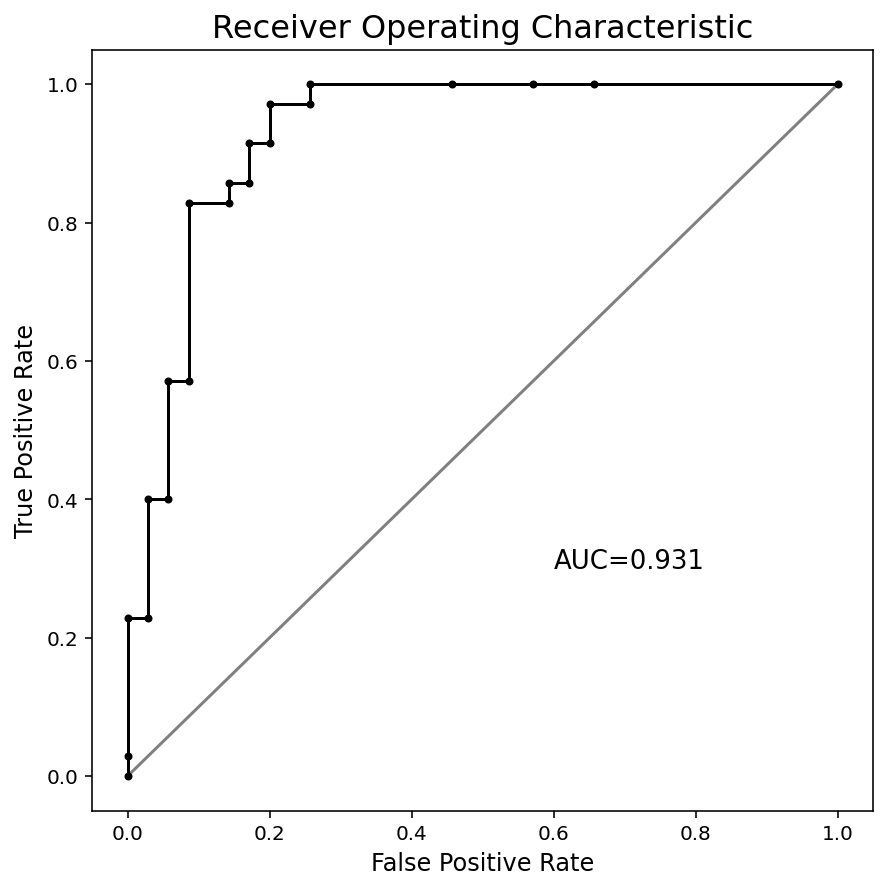

In [42]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
baseline_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
probs = gb_clf2.predict_proba(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))
probs = probs[:, 1]

# calculate scores
baseline_auc = roc_auc_score(y_test, baseline_probs)
auc = roc_auc_score(y_test, probs)
auc = ('AUC=%.3f' % (auc))

# calculate roc curves
baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
fpr, tpr, _ = roc_curve(y_test, probs)

# plot the roc curve for the model
ax.plot(baseline_fpr, baseline_tpr, color='gray')
ax.plot(fpr, tpr, marker='.', color='black')

# axis labels
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
ax.set_title('Receiver Operating Characteristic', fontsize=16)
plt.text(.6, .3, auc, fontsize=13)

# plt.savefig('Figs/TM_GBC_ROC.png', dpi = 600)

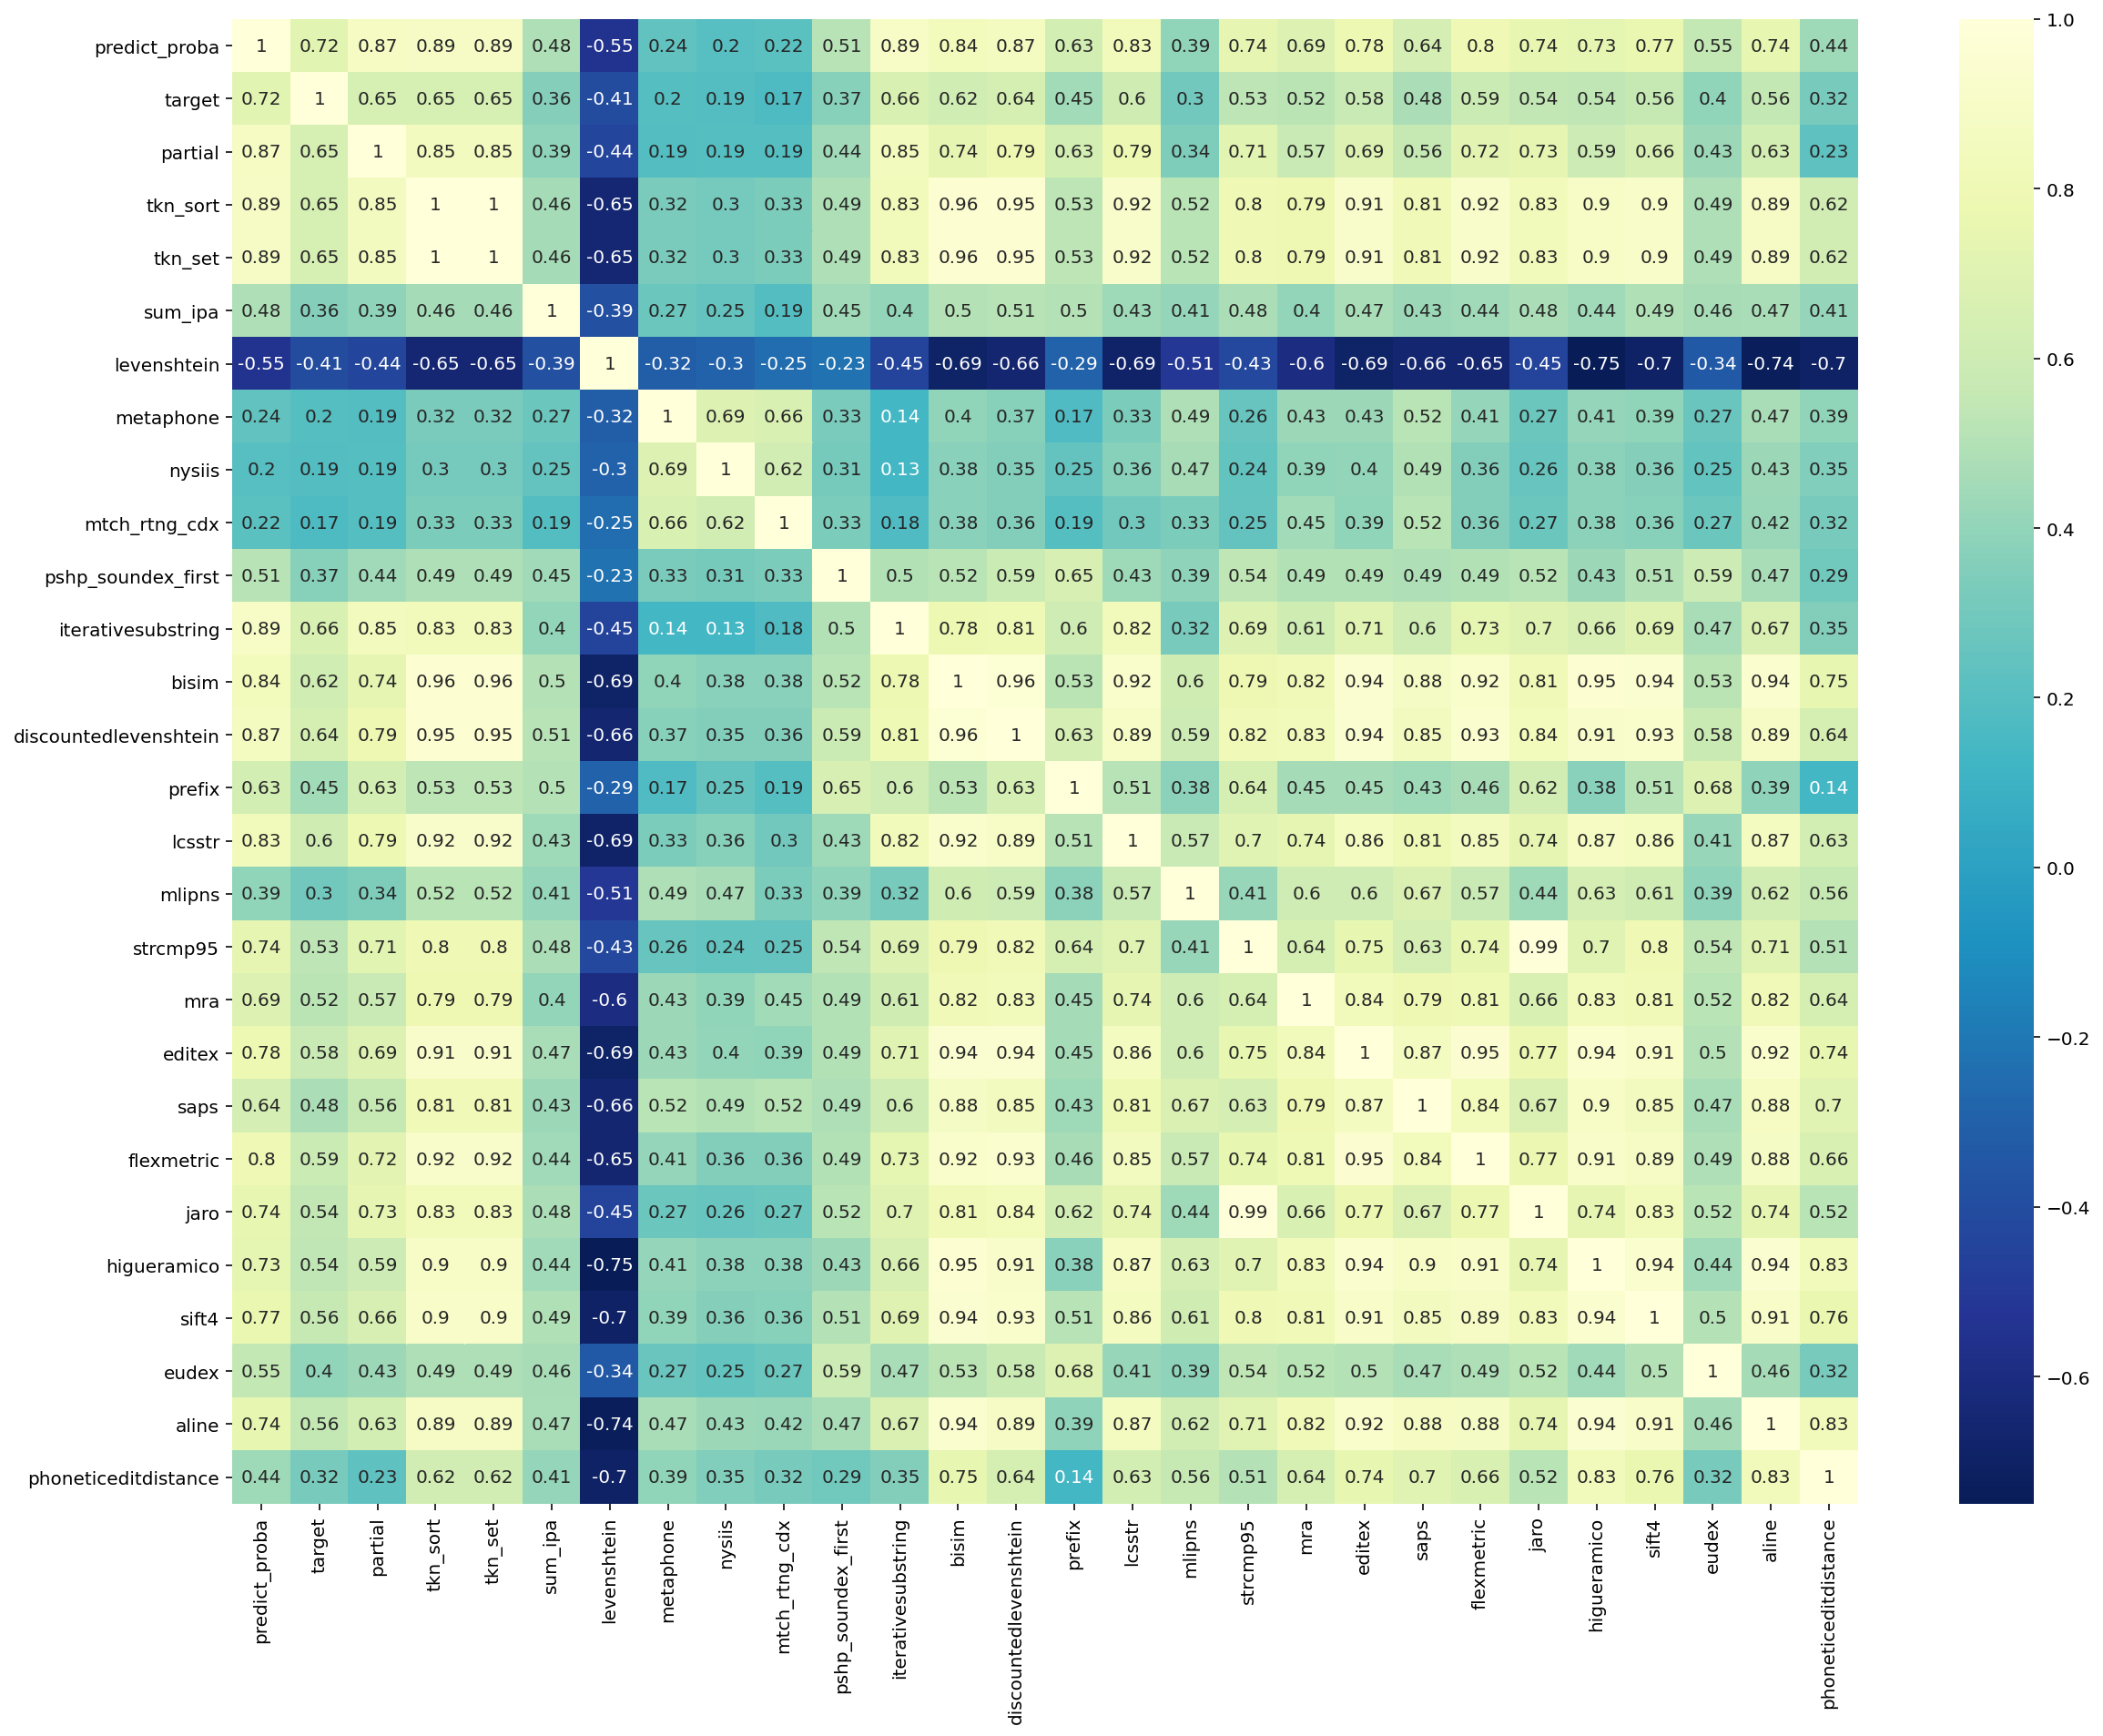

In [43]:
import seaborn as sns

corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot = True,
            cmap="YlGnBu_r")
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# XGboost

In [ ]:
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

y = df.target
X = df.drop(columns = ['target','predict_proba'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
D_train = xgb.DMatrix(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1), label=y_train)
D_test = xgb.DMatrix(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1), label=y_test)

param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 3}

steps = 20  # The number of training iterations

xgbmodel = xgb.train(param, D_train, steps)

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

preds = xgbmodel.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

In [ ]:
from sklearn.model_selection import GridSearchCV

clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=10)

grid.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y_train)

In [ ]:
import pickle

# Dictionary of best parameters
best_pars = grid.best_params_
# Best XGB model that was found based on the metric score you specify
best_model = grid.best_estimator_
# Save model
pickle.dump(grid.best_estimator_, open("Data.nosync/TM_XGboost_classifier.pkl", "wb"))

### Test saved model

In [ ]:
import pickle
import numpy as np

# load the model from disk
loaded_model = pickle.load(open("Data.nosync/TM_XGboost_classifier.pkl", 'rb'))
result = loaded_model.score(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y_test)
print(result)

In [ ]:
proba_result = loaded_model.predict_proba(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

paa = [p[1] for p in proba_result]

paa




In [ ]:
loaded_model.predict(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

In [ ]:
# Import pandas library 
import pandas as pd 
  
# initialize list of lists 
data = [['Flipn Chicken','Frickn Chicken']] 
  
# Create the pandas DataFrame 
mydf = pd.DataFrame(data, columns = ['bboyaa', 'fdslkajsdf']) 
  
# print dataframe. 
mydf 

In [ ]:
featurize(mydf)

In [ ]:
foo = featurize(mydf)
foo2 = foo.drop(['a', 'b', 'TM_A', 'TM_B'], 1)

foo3 = loaded_model.predict_proba(foo2)

foo4 = [p[1] for p in foo3]

foo4

In [ ]:
def XGboost_ratio(data):
    df = featurize(data)
    df2 = df.drop(['a', 'b', 'TM_A', 'TM_B'], 1)
    df3 = loaded_model.predict_proba(df2)
    df4 = [p[1] for p in df3]
    return df4

In [ ]:
XGboost_ratio(mydf)

In [ ]:
import pandas as pd

df = pd.read_csv("Data.nosync/TM_clean_soundex.csv", index_col = False)

# df_matches = df[df.apply(get_ratio, axis = 1) > 70]

# df = df['wordmark']

df.head(5)

In [ ]:


# df.loc[df.str.startswith('f', na=False)]
clean_text = 'flipn chicken'
first_char = clean_text[0]
last_char = clean_text[-6:]

combo = '^' + first_char + '|' + last_char + '$'
# combo = last_char + '$'

combo
# str.contains("^(?:N|M|V|R)")]

df2= df[df['wordmark'].str.contains(combo, na = False)]
# # df.loc[df['wordmark'].str.startswith(first_char, na=False)]

df2

In [ ]:
from itertools import izip

# def pairwise(t):
#     it = iter(t)
#     return izip(it,it)

# for "pairs" of any length
# def chunkwise(t, size=2):
#     it = iter(t)
#     return izip(*[it]*size)

### Evaluate XGboost

In [ ]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
baseline_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
probs = grid.predict_proba(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))
probs = probs[:, 1]

# calculate scores
baseline_auc = roc_auc_score(y_test, baseline_probs)
auc = roc_auc_score(y_test, probs)
auc = ('AUC=%.3f' % (auc))

# calculate roc curves
baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
fpr, tpr, _ = roc_curve(y_test, probs)

# plot the roc curve for the model
ax.plot(baseline_fpr, baseline_tpr, color='gray')
ax.plot(fpr, tpr, marker='.', color='black')

# axis labels
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
ax.set_title('Receiver Operating Characteristic', fontsize=16)
plt.text(.6, .3, auc, fontsize=13)

# plt.savefig('Figs/TM_XGBoost_ROC.png', dpi = 600)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, best_preds))

print("Classification Report")
print(classification_report(y_test, best_preds))

In [ ]:
import joblib

xgbmodel.dump_model('Data.nosync/TM_XGBoost_model.pkl')

In [ ]:
from xgboost import plot_importance
from matplotlib import pyplot

plt.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'retina'

plot_importance(xgbmodel)
# pyplot.show()
# plt.savefig("Figs/TM_XGboost_feature_importance.png", format='png', dpi=600, bbox_inches='tight')

In [ ]:
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(xgbmodel)
shap_values = explainer.shap_values(X.drop(['a', 'b', 'TM_A', 'TM_B'], 1))


shap.summary_plot(shap_values[0], X.drop(['a', 'b', 'TM_A', 'TM_B'], 1), plot_type="bar", show=False)
# plt.savefig("Figs/TM_XGboost_SHAP_features.png", format='png', dpi=600, bbox_inches='tight')

In [ ]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("discountedlevenshtein", shap_values[0],
                     X.drop(['a', 'b', 'TM_A', 'TM_B'], 1))


In [ ]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("iterativesubstring", shap_values[0],
                     X.drop(['a', 'b', 'TM_A', 'TM_B'], 1))


In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values[0],
                X.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

# Grid Search   

Hyperparameter tuning

In [ ]:
cols = [col for col in df.columns if col not in ['a', 'b', 'TM_A', 'TM_B', 'target', 'predict_proba']]
comb2 = list(combinations(cols, 2))
comb3 = list(combinations(cols, 3))
colgrid = [(col,)for col in cols]+comb2+comb3


colgrid

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, df.target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
clf = LogisticRegression()
grid_clf = GridSearchCV(clf, param_grid = {'C':np.logspace(-4, 4, 20)}, scoring = 'precision', verbose=0)

scores = []
for cols in colgrid:
    grid_clf.fit(X_train[['predict_proba']+list(cols)], y_train)
    y_pred = grid_clf.predict(X_val[['predict_proba']+list(cols)])
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    scores.append([str(cols), tn, fp, fn, tp])

In [ ]:
scores_df = pd.DataFrame(scores)

In [ ]:
scores_df.columns = ['features', 'tn', 'fp', 'fn', 'tp']

In [ ]:
scores_df.head()

In [ ]:
scores_df['error'] = scores_df['fp'] + scores_df['fn']

In [ ]:
scores_df = scores_df.sort_values(['error', 'fp'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, df.target, test_size=0.2, random_state=42)

In [ ]:
selected_cols = ['discountedlevenshtein', 'phoneticeditdistance', 'iterativesubstring', 'sum_ipa']

In [ ]:
clf = LogisticRegression()
grid_clf = GridSearchCV(clf, param_grid = {'C':np.logspace(-4, 4, 20)}, scoring='precision')
grid_clf.fit(X_train[selected_cols], y_train)
y_pred = grid_clf.predict(X_test[selected_cols])

In [ ]:
print(grid_clf.best_params_)

## Evaluation

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
def evaluate(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    conf_matrix = pd.DataFrame(data=cm, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1'])
    print(classification_report(y_test, y_pred))
    print(conf_matrix)

In [ ]:
evaluate(y_test, y_pred)

In [ ]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
baseline_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
probs = grid_clf.predict_proba(X_test[selected_cols])
probs = probs[:, 1]

# calculate scores
baseline_auc = roc_auc_score(y_test, baseline_probs)
auc = roc_auc_score(y_test, probs)
auc = ('AUC=%.3f' % (auc))

# calculate roc curves
baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
fpr, tpr, _ = roc_curve(y_test, probs)

# plot the roc curve for the model
ax.plot(baseline_fpr, baseline_tpr, color='gray')
ax.plot(fpr, tpr, marker='.', color='black')

# axis labels
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
ax.set_title('Receiver Operating Characteristic', fontsize=16)
plt.text(.6, .3, auc, fontsize=13)

### Export Models and Pipeline

In [ ]:
import joblib
import json

In [ ]:
base_1 = base_model_1(X.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y, X_test=None, export=True)
joblib.dump(base_1, filename='Data.nosync/TM_Gradient_boost_base_model.pkl')

In [ ]:
# base_model_2(X[['name_a', 'name_b']], y, X_test=None, export=True)

In [ ]:
joblib.dump(grid_clf.best_estimator_, filename='Data.nosync/TM_meta_model.pkl')